In [50]:
import datetime
import json
import os
import sys
import time
import re
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from bs4 import BeautifulSoup
import numpy as np
from baseball_scraper import pitching_stats_bref
from baseball_scraper import batting_stats_bref
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [3]:
sys.path.append("..")
pitch_path  = '../baseball2020/bref_seasons/pitching/'  
bat_path  = '../baseball2020/bref_seasons/batting/' 
call = 'gotime'

In [4]:
def main():
    start_time = time.time()
    if call.startswith('gotime'):
        pitch_looper()
        bat_looper()
    else:
        print('this failed')
    elapsed = time.time() - start_time
    print('Elapsed time: %s' % format_seconds(elapsed))
    
def pitch_fetcher(year):
    filename = pitch_path + 'pitching_data' + str(year) + '.csv'
    year_pitching = pitching_stats_bref(year)
    pitching_df = pd.DataFrame(year_pitching) 
    pitching_df['season']=year
    pitching_df.to_csv(filename, index=False)
    return pitching_df

def pitch_looper(): 
    years = [2015,2016,2017,2018,2019]
    for year in years:
        pitch_fetcher(year)
        print('fetching data...')
        
def bat_fetcher(year):
    filename = bat_path + 'batting_data' + str(year) + '.csv'
    year_batting = batting_stats_bref(year)
    batting_df = pd.DataFrame(year_batting) 
    batting_df['season']=year
    batting_df.to_csv(filename, index=False)
    return batting_df

def bat_looper(): 
    years = [2015,2016,2017,2018,2019]
    for year in years:
        bat_fetcher(year)
        print('fetching data...')

def format_seconds(seconds):
    if seconds > 60:
        minutes, seconds = seconds // 60, seconds % 60
        return '%d:%02.2f minutes' % (minutes, seconds)
    return '%.2f seconds' % seconds

if __name__ == '__main__':
    main()

fetching data...
fetching data...
fetching data...
fetching data...
fetching data...
fetching data...
fetching data...
fetching data...
fetching data...
fetching data...
Elapsed time: 2:30.36 minutes


In [5]:
#load all of your files into two data frames
import glob
pitch_files = glob.glob(os.path.join(pitch_path, "*.csv"))
pitching = pd.concat((pd.read_csv(f) for f in pitch_files))
bat_files = glob.glob(os.path.join(bat_path, "*.csv"))
batting = pd.concat((pd.read_csv(f) for f in bat_files))

In [6]:
#see how big your new datafram is, take a look at the data
len(pitching)

3862

In [7]:
pitching.head()

,Name,Age,#days,Lev,Tm,G,GS,W,L,SV,...,StL,StS,GB/FB,LD,PU,WHIP,BAbip,SO9,SO/W,season
0,Fernando Abad,33,184,MLB-NL,San Francisco,21,0,NaN,2.0,NaN,...,0.25,0.11,0.62,0.19,0.03,0.923,0.200,6.2,3.00,2019
1,Bryan Abreu,22,183,MLB-AL,Houston,7,0,NaN,NaN,NaN,...,0.19,0.19,0.50,0.31,0.00,0.808,0.250,13.5,4.33,2019
2,Jason Adam,27,183,MLB-AL,Toronto,23,0,3.0,NaN,NaN,...,0.13,0.11,0.29,0.24,0.18,1.154,0.237,7.5,1.80,2019
3,Austin Adams,32,268,MLB-AL,"Minnesota,Detroit",15,0,NaN,NaN,NaN,...,0.14,0.11,0.42,0.21,0.09,1.860,0.286,7.6,1.08,2019
4,Austin Adams,28,191,"MLB-AL,MLB-NL","Seattle,Washington",30,2,2.0,2.0,NaN,...,0.18,0.16,0.50,0.18,0.05,1.125,0.286,14.9,3.31,2019


In [8]:
#create a subset of pitching data for 2019, then select only pitchers with at least 15 games started, 
#confirm by looking at the first few rows
pitching_2019 = pitching[pitching['season'] == 2019]
pitching_2019 = pitching_2019[pitching_2019['GS'] > 14]
pitching_2019.head()

,Name,Age,#days,Lev,Tm,G,GS,W,L,SV,...,StL,StS,GB/FB,LD,PU,WHIP,BAbip,SO9,SO/W,season
12,Sandy Alcantara,23,183,MLB-NL,Miami,32,32,6.0,14.0,NaN,...,0.15,0.11,0.45,0.23,0.07,1.318,0.274,6.9,1.86,2019
25,Brett Anderson,31,184,MLB-AL,Oakland,31,31,13.0,9.0,NaN,...,0.17,0.08,0.55,0.24,0.04,1.302,0.280,4.6,1.84,2019
26,Chase Anderson,31,186,MLB-NL,Milwaukee,32,27,8.0,4.0,NaN,...,0.15,0.11,0.34,0.23,0.12,1.266,0.270,8.0,2.48,2019
31,Shaun Anderson,24,185,MLB-NL,San Francisco,28,16,3.0,5.0,2.0,...,0.14,0.09,0.41,0.32,0.07,1.552,0.327,6.6,1.84,2019
37,Chris Archer,30,223,MLB-NL,Pittsburgh,23,23,3.0,9.0,NaN,...,0.17,0.13,0.36,0.31,0.07,1.412,0.304,10.8,2.60,2019


count    146.000000
mean       8.728767
std        1.786808
min        4.600000
25%        7.400000
50%        8.700000
75%        9.875000
max       13.800000
Name: SO9, dtype: float64


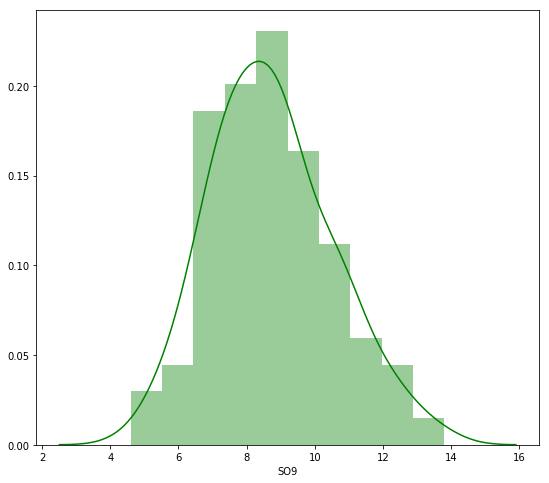

In [9]:
#Take a look at the distribution and summary statistics for a single variable
print(pitching_2019['SO9'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(pitching_2019['SO9'], color='g', bins=10, hist_kws={'alpha': 0.4});

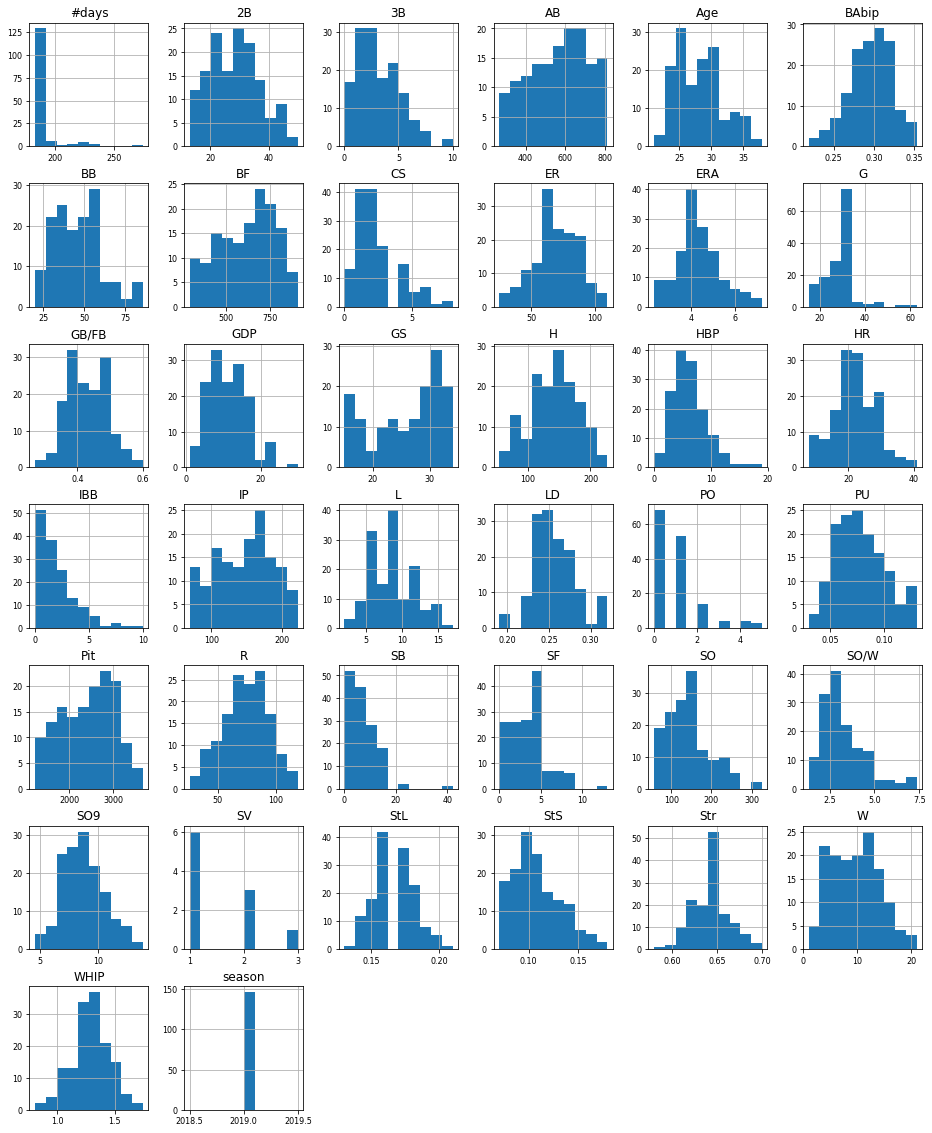

In [10]:
#look at histograms for ALL variables
pitching_2019.hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8);

In [11]:
batting.head()

,Name,Age,#days,Lev,Tm,G,PA,AB,R,H,...,SF,GDP,SB,CS,BA,OBP,SLG,OPS,mlb_ID,season
0,David Aardsma,33,1731,MLB-NL,Atlanta,1,1,1,0,0,...,0,0,0,0,0.000,0.000,0.000,0.000,430911,2015
1,Jose Abreu,28,1640,MLB-AL,Chicago,154,668,613,88,178,...,1,16,0,0,0.290,0.347,0.502,0.850,547989,2015
2,Dustin Ackley,27,1639,MLB-AL,"New York,Seattle",100,264,238,28,55,...,4,3,2,2,0.231,0.284,0.429,0.712,554429,2015
3,Cristhian Adames,23,1639,MLB-NL,Colorado,24,58,53,4,13,...,0,0,0,1,0.245,0.298,0.302,0.600,542436,2015
4,Austin Adams,28,1713,MLB-AL,Cleveland,1,1,1,0,0,...,0,1,0,0,0.000,0.000,0.000,0.000,542866,2015


In [12]:
#create a subset of batting data for 2019, then select only batters with at least 350 plate appearances, 
#confirm by looking at the first few rows
batting_2019 = batting[batting['season'] == 2019]
batting_2019 = batting_2019[batting_2019['PA'] > 350]
batting_2019.head()

,Name,Age,#days,Lev,Tm,G,PA,AB,R,H,...,SF,GDP,SB,CS,BA,OBP,SLG,OPS,mlb_ID,season
0,Jose Abreu,32,183,MLB-AL,Chicago,159,693,634,85,180,...,10,24,2,2,0.284,0.330,0.503,0.834,547989,2019
1,Ronald Acuna Jr.,21,188,MLB-NL,Atlanta,156,715,626,127,175,...,1,8,37,8,0.280,0.365,0.518,0.883,660670,2019
3,Willy Adames,23,183,MLB-AL,Tampa Bay,152,584,531,69,135,...,1,9,4,2,0.254,0.317,0.418,0.735,642715,2019
9,Jesus Aguilar,29,183,"MLB-AL,MLB-NL","Tampa Bay,Milwaukee",131,369,314,39,74,...,7,12,0,0,0.236,0.325,0.389,0.714,542583,2019
10,Nick Ahmed,29,183,MLB-NL,Arizona,158,625,556,79,141,...,12,15,8,1,0.254,0.316,0.437,0.753,605113,2019


In [30]:
batting_2019.describe()

,Age,#days,G,PA,AB,R,H,2B,3B,HR,...,SF,GDP,SB,CS,BA,OBP,SLG,OPS,mlb_ID,season
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,...,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.0
mean,27.925311,186.149378,132.369295,525.273859,468.161826,70.074689,124.601660,25.261411,2.352697,20.937759,...,3.402490,9.751037,6.970954,2.037344,0.263888,0.335842,0.459158,0.794954,569248.775934,2019.0
std,3.712959,9.012173,19.018427,104.984799,92.792391,22.528746,32.380406,8.535351,2.174685,10.515478,...,2.222947,4.823148,8.321858,2.223608,0.029378,0.031967,0.072051,0.096978,67060.575625,0.0
min,20.000000,183.000000,84.000000,352.000000,303.000000,26.000000,55.000000,9.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.179000,0.262000,0.275000,0.564000,405395.000000,2019.0
25%,25.000000,183.000000,119.000000,439.000000,391.000000,52.000000,99.000000,19.000000,1.000000,12.000000,...,2.000000,6.000000,2.000000,0.000000,0.244000,0.313000,0.410000,0.727000,519203.000000,2019.0
50%,27.000000,183.000000,134.000000,520.000000,470.000000,67.000000,120.000000,24.000000,2.000000,20.000000,...,3.000000,10.000000,4.000000,1.000000,0.262000,0.334000,0.452000,0.785000,592348.000000,2019.0
75%,30.000000,184.000000,148.000000,613.000000,545.000000,83.000000,149.000000,31.000000,3.000000,29.000000,...,5.000000,13.000000,10.000000,3.000000,0.282000,0.356000,0.515000,0.856000,621035.000000,2019.0
max,39.000000,241.000000,162.000000,747.000000,681.000000,135.000000,206.000000,58.000000,10.000000,53.000000,...,12.000000,24.000000,46.000000,10.000000,0.344000,0.438000,0.672000,1.102000,670541.000000,2019.0


In [13]:
#let's see how the main batting stats are affected by age of the player
batting_age = batting_2019.groupby(['Age']).agg({'OBP':'mean', 'SLG': 'mean', 'OPS': 'mean', 'mlb_ID': pd.Series.nunique}).reset_index()
batting_age.head(20)

,Age,OBP,SLG,OPS,mlb_ID
0,20,0.373000,0.523667,0.896667,3
1,21,0.365000,0.518000,0.883000,1
2,22,0.352875,0.497500,0.850250,8
3,23,0.327750,0.463000,0.790750,8
4,24,0.325810,0.451429,0.777190,21
5,25,0.326583,0.443542,0.770042,24
6,26,0.336406,0.472906,0.809313,32
7,27,0.339704,0.486037,0.825704,27
8,28,0.337800,0.460760,0.798560,25
9,29,0.335524,0.448143,0.783619,21


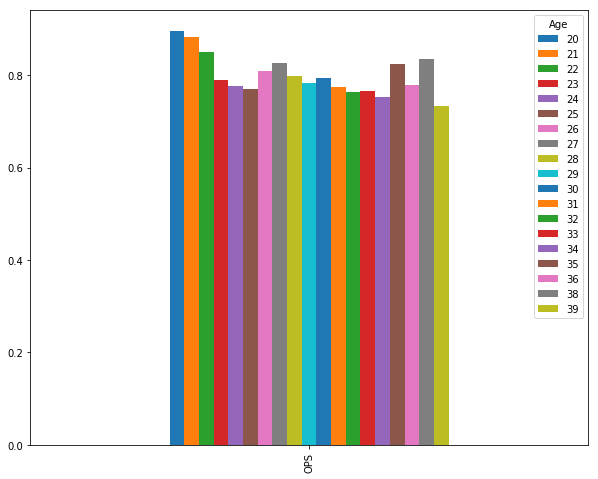

In [14]:
#Let's see how batting performance relates to player age
pd.pivot_table(batting_2019, values = 'OPS',  columns=['Age'], aggfunc=np.mean).plot.bar(stacked=False, figsize=(10,8))   


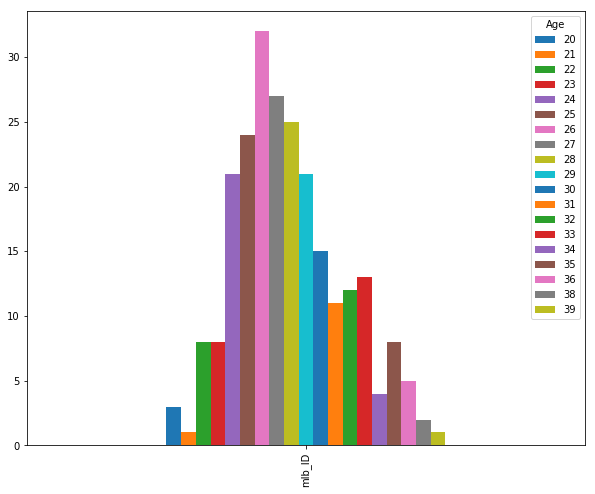

In [15]:
#now lets see how many players qualified by number of PAs in each age bracket
pd.pivot_table(batting_2019, values = 'mlb_ID',  columns=['Age'], aggfunc=pd.Series.nunique).plot.bar(stacked=False, figsize=(10,8))   


In [16]:
#now we need to create a dataframe that we can use to build a predictive model from, so we need to take the variable 
#we want to predict (the following year's OPS) and stick it on the end of the previous year's data
#Note the use of the merge() and append() functions in pandas
batting_2016 = batting[batting['season'] == 2016]
batting_2016 = batting_2016[batting_2016['PA'] > 350]
batting_2017 = batting[batting['season'] == 2017]
batting_2017 = batting_2017[batting_2017['PA'] > 350]
batting_2018 = batting[batting['season'] == 2018]
batting_2018 = batting_2018[batting_2018['PA'] > 350]
bat_pred_16 = pd.merge(batting_2016, batting_2017[['Name','OPS']], left_on='Name', right_on='Name')

In [24]:
print(len(bat_pred_16))
bat_pred_16.head()

176


,Name,Age,#days,Lev,Tm,G,PA,AB,R,H,...,GDP,SB,CS,BA,OBP,SLG,OPS_x,mlb_ID,season,OPS_y
0,Jose Abreu,29,1275,MLB-AL,Chicago,159,695,624,67,183,...,21,0,0,0.293,0.353,0.468,0.820,547989,2016,0.906
1,Yonder Alonso,29,1275,MLB-AL,Oakland,151,532,482,52,122,...,15,3,1,0.253,0.316,0.367,0.683,475174,2016,0.868
2,Jose Altuve,26,1275,MLB-AL,Houston,161,717,640,108,216,...,15,30,8,0.338,0.396,0.531,0.928,514888,2016,0.957
3,Tim Anderson,23,1275,MLB-AL,Chicago,98,431,410,57,116,...,15,10,1,0.283,0.306,0.432,0.738,641313,2016,0.679
4,Elvis Andrus,27,1275,MLB-AL,Texas,146,568,506,75,153,...,18,24,7,0.302,0.362,0.439,0.800,462101,2016,0.808


In [18]:
bat_pred_17 = pd.merge(batting_2017, batting_2018[['Name','OPS']], left_on='Name', right_on='Name')
bat_pred_18 = pd.merge(batting_2018, batting_2019[['Name','OPS']], left_on='Name', right_on='Name')

In [28]:
model_data = bat_pred_16
model_data = model_data.append(bat_pred_17)
model_data = model_data.append(bat_pred_18)

In [29]:
model_data.shape

(522, 30)

In [33]:
#so, if we want to predict the next year's OPS (as a proxy for fantasy success), we need to do better than just
#the previous year's OPS
bat_pred_16['OPS_x'].corr(bat_pred_16['OPS_y'])

0.4436371901667702

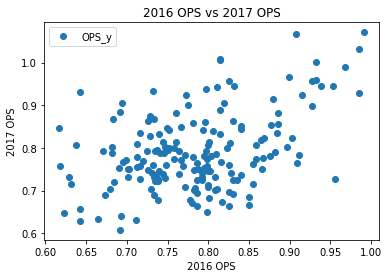

In [35]:
#scatter plot can help us get a sense of this relationship, and how loose it is
bat_pred_16.plot(x='OPS_x', y='OPS_y', style='o')  
plt.title('2016 OPS vs 2017 OPS')  
plt.xlabel('2016 OPS')  
plt.ylabel('2017 OPS')  
plt.show()

In [ ]:
#we can look at age as another possible predictor (remember, values close to 0 indicate no relationship)
bat_pred_16['Age'].corr(bat_pred_16['OPS_y'])

In [45]:
X = model_data.iloc[1:,:28]
y = model_data.OPS_y

In [46]:
X.shape

(522, 28)

In [47]:
X.head()

,Name,Age,#days,Lev,Tm,G,PA,AB,R,H,...,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS_x,mlb_ID
0,Jose Abreu,29,1275,MLB-AL,Chicago,159,695,624,67,183,...,0,9,21,0,0,0.293,0.353,0.468,0.820,547989
1,Yonder Alonso,29,1275,MLB-AL,Oakland,151,532,482,52,122,...,0,4,15,3,1,0.253,0.316,0.367,0.683,475174
2,Jose Altuve,26,1275,MLB-AL,Houston,161,717,640,108,216,...,3,7,15,30,8,0.338,0.396,0.531,0.928,514888
3,Tim Anderson,23,1275,MLB-AL,Chicago,98,431,410,57,116,...,6,1,15,10,1,0.283,0.306,0.432,0.738,641313
4,Elvis Andrus,27,1275,MLB-AL,Texas,146,568,506,75,153,...,4,7,18,24,7,0.302,0.362,0.439,0.800,462101


In [54]:
#we don't want to try and do math on the words, and mlbID isn't meaningful, so we need to drop them from our data set
X = X.drop(['Name','#days','Lev','Tm','mlb_ID'], axis = 1)

In [55]:
X.head()

,Age,G,PA,AB,R,H,2B,3B,HR,RBI,...,HBP,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS_x
0,29,159,695,624,67,183,32,1,25,100,...,15,0,9,21,0,0,0.293,0.353,0.468,0.820
1,29,151,532,482,52,122,34,0,7,56,...,1,0,4,15,3,1,0.253,0.316,0.367,0.683
2,26,161,717,640,108,216,42,5,24,96,...,7,3,7,15,30,8,0.338,0.396,0.531,0.928
3,23,98,431,410,57,116,22,6,9,30,...,1,6,1,15,10,1,0.283,0.306,0.432,0.738
4,27,146,568,506,75,153,31,7,8,69,...,4,4,7,18,24,7,0.302,0.362,0.439,0.800


In [48]:
y.shape

(522,)

In [49]:
y.head()

0    0.906
1    0.868
2    0.957
3    0.679
4    0.808
Name: OPS_y, dtype: float64

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [57]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
#To retrieve the intercept:
print(regressor.intercept_)#For retrieving the slope:
print(regressor.coef_)

0.9813881933315556
[-3.82087183e-03 -5.94038970e-04 -2.90730470e-04 -5.37658759e-05
  5.92502274e-04  4.57008849e-04  4.98048745e-04  6.83016647e-04
 -3.33518498e-03  4.20597963e-04  4.08041045e-03  2.12287941e-03
 -2.48182641e-04  3.81875771e-03 -7.64518922e-03 -1.43183046e-03
  1.13167932e-03  2.17078166e-05 -8.61519267e-04  1.44578391e+00
  1.22918720e+01  1.56456880e+01 -1.48288465e+01]


In [64]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
Age,-0.003821
G,-0.000594
PA,-0.000291
AB,-0.000054
R,0.000593
H,0.000457
2B,0.000498
3B,0.000683
HR,-0.003335
RBI,0.000421


In [59]:
y_pred = regressor.predict(X_test)

In [62]:
#check your predictions
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
54,0.875,0.773455
118,0.629,0.706454
75,0.771,0.722067
126,0.701,0.766340
94,0.671,0.699191
...,...,...
91,0.854,0.844249
97,0.716,0.803059
173,0.807,0.859519
175,0.693,0.831753


In [63]:
#check the correlation of the actual versus predicted values, see if it is better (higher) than just OPS
df['Actual'].corr(df['Predicted'])

0.5387638596686658

In [61]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.06916763043958203
Mean Squared Error: 0.007050907448033218
Root Mean Squared Error: 0.08396968171925637


In [ ]:
#so far, the results are a little better, but not much, so we are going to need to go deeper... 
#...and do some FEATURE CREATION!